In [1]:
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm


# Multi-GPU device setup
def setup_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        gpu_count = torch.cuda.device_count()
        print(f"CUDA available: {gpu_count} GPU(s)")
        for i in range(gpu_count):
            print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")
        return device, gpu_count
    else:
        print("CUDA not available, using CPU")
        return torch.device("cpu"), 0


device, gpu_count = setup_device()
use_multi_gpu = gpu_count > 1

CUDA available: 4 GPU(s)
  GPU 0: NVIDIA GH200 120GB
  GPU 1: NVIDIA GH200 120GB
  GPU 2: NVIDIA GH200 120GB
  GPU 3: NVIDIA GH200 120GB


In [2]:
# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


# Create model and setup multi-GPU if available
model = CNN().to(device)

if use_multi_gpu:
    print(f"Using DataParallel with {gpu_count} GPUs")
    model = nn.DataParallel(model)
    # Increase batch size for multi-GPU
    batch_size_multiplier = gpu_count
else:
    batch_size_multiplier = 1

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Using DataParallel with 4 GPUs
Model parameters: 1,199,882


In [3]:
# Load data with adjusted batch size for multi-GPU
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

# Load datasets
train_dataset = torchvision.datasets.FashionMNIST(
    "./data", train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.FashionMNIST(
    "./data", train=False, transform=transform
)

# Adjust batch size for multi-GPU
base_batch_size = 512
batch_size = base_batch_size * batch_size_multiplier
test_batch_size = batch_size * 2

# Create data loaders with increased workers for multi-GPU
num_workers = min(8, gpu_count * 2) if use_multi_gpu else 2

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True if torch.cuda.is_available() else False,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True if torch.cuda.is_available() else False,
)

print(f"Training samples: {len(train_dataset):,}")
print(f"Test samples: {len(test_dataset):,}")
print(f"Batch size: {batch_size} (base: {base_batch_size} × {batch_size_multiplier})")
print(f"Batches per epoch: {len(train_loader):,}")
print(f"Workers: {num_workers}")

Training samples: 60,000
Test samples: 10,000
Batch size: 2048 (base: 512 × 4)
Batches per epoch: 30
Workers: 8


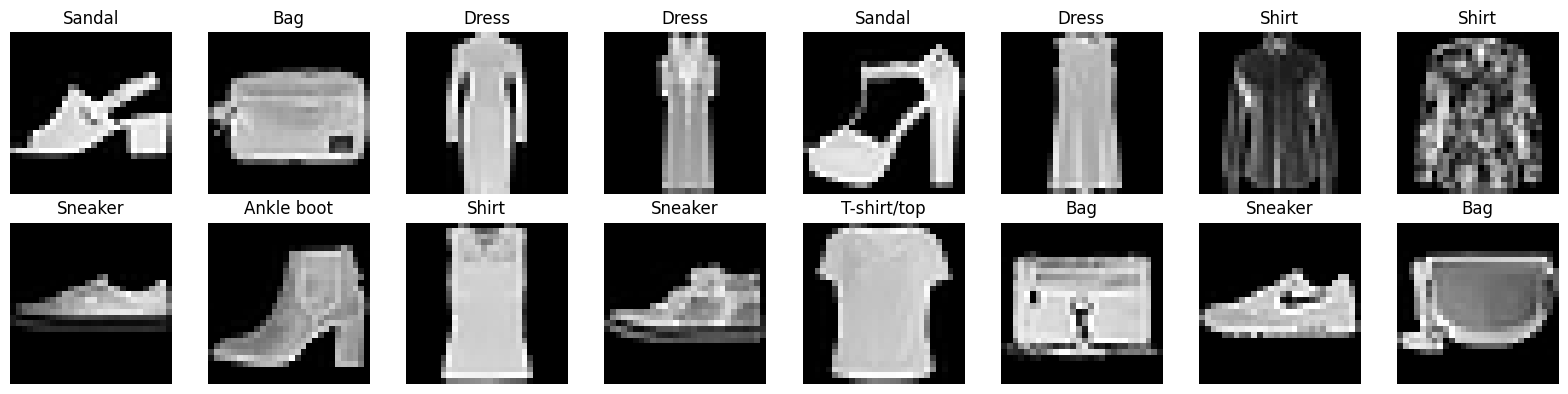

Batch shape: torch.Size([2048, 1, 28, 28])
Min pixel value: -0.424
Max pixel value: 2.821
Mean pixel value: 0.513
Std pixel value: 1.148


In [4]:
# Preview data
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

# Get a batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Plot sample images
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i in range(16):
    row, col = i // 8, i % 8
    img = images[i].squeeze()
    axes[row, col].imshow(img, cmap="gray")
    axes[row, col].set_title(f"{class_names[labels[i]]}")
    axes[row, col].axis("off")

plt.tight_layout()
plt.show()

print(f"Batch shape: {images.shape}")
print(f"Min pixel value: {images.min():.3f}")
print(f"Max pixel value: {images.max():.3f}")
print(f"Mean pixel value: {images.mean():.3f}")
print(f"Std pixel value: {images.std():.3f}")

In [5]:
# Helper functions
def get_gpu_memory_usage():
    if torch.cuda.is_available():
        memory_info = []
        for i in range(torch.cuda.device_count()):
            allocated = torch.cuda.memory_allocated(i) / 1024**3
            cached = torch.cuda.memory_reserved(i) / 1024**3
            memory_info.append(f"GPU{i}: {allocated:.1f}GB/{cached:.1f}GB")
        return " | ".join(memory_info)
    return "CPU"


def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device, non_blocking=True), target.to(
                device, non_blocking=True
            )
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    accuracy = 100.0 * correct / total
    avg_loss = test_loss / len(test_loader)
    return avg_loss, accuracy


def save_checkpoint(
    model,
    optimizer,
    epoch,
    batch_idx,
    loss,
    checkpoint_dir,
    train_losses=None,
    test_losses=None,
    test_accuracies=None,
):
    checkpoint_dir = Path(checkpoint_dir)
    checkpoint_dir.mkdir(exist_ok=True)

    # Handle DataParallel model state dict
    model_state_dict = (
        model.module.state_dict() if hasattr(model, "module") else model.state_dict()
    )

    checkpoint = {
        "epoch": epoch,
        "batch_idx": batch_idx,
        "model_state_dict": model_state_dict,
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": loss,
        "timestamp": time.time(),
        "gpu_count": gpu_count,
        "use_multi_gpu": use_multi_gpu,
        "train_losses": train_losses,
        "test_losses": test_losses,
        "test_accuracies": test_accuracies,
    }

    checkpoint_path = (
        checkpoint_dir / f"checkpoint_epoch_{epoch:02d}_batch_{batch_idx}.pt"
    )
    torch.save(checkpoint, checkpoint_path)

    # Keep only last 3 checkpoints
    checkpoints = sorted(checkpoint_dir.glob("checkpoint_*.pt"))
    if len(checkpoints) > 3:
        for old_checkpoint in checkpoints[:-3]:
            old_checkpoint.unlink()

    return checkpoint_path

In [6]:
# Auto-load checkpoints
def find_latest_checkpoint(checkpoint_dir):
    """Find the most recent checkpoint in the directory"""
    checkpoint_dir = Path(checkpoint_dir)
    if not checkpoint_dir.exists():
        return None

    checkpoints = list(checkpoint_dir.glob("checkpoint_*.pt"))
    if not checkpoints:
        return None

    # Sort by modification time (most recent first)
    checkpoints.sort(key=lambda x: x.stat().st_mtime, reverse=True)
    return checkpoints[0]


def load_checkpoint(checkpoint_path, model, optimizer=None):
    """Load model from checkpoint, handling multi-GPU scenarios"""
    print(f"Loading checkpoint: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Handle loading single-GPU checkpoint on multi-GPU setup or vice versa
    state_dict = checkpoint["model_state_dict"]

    if hasattr(model, "module"):  # Current model is DataParallel
        if not any(key.startswith("module.") for key in state_dict.keys()):
            # Checkpoint is single-GPU, current model is multi-GPU
            state_dict = {f"module.{k}": v for k, v in state_dict.items()}
    else:  # Current model is single-GPU
        if any(key.startswith("module.") for key in state_dict.keys()):
            # Checkpoint is multi-GPU, current model is single-GPU
            state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}

    model.load_state_dict(state_dict)

    if optimizer is not None:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    print(f"✓ Loaded checkpoint from epoch {checkpoint['epoch']}")
    print(f"✓ Checkpoint was trained with {checkpoint.get('gpu_count', 1)} GPU(s)")
    print(f"✓ Last recorded loss: {checkpoint['loss']:.4f}")
    print(
        f"✓ Checkpoint timestamp: {time.ctime(checkpoint.get('timestamp', time.time()))}"
    )

    return checkpoint


def auto_load_checkpoint(model, checkpoint_dir="./checkpoints", auto_load=True):
    """Automatically check and load the most recent checkpoint"""
    latest_checkpoint = find_latest_checkpoint(checkpoint_dir)

    if latest_checkpoint is not None:
        print("🔍 Found existing checkpoints!")
        print(f"📁 Checkpoint directory: {checkpoint_dir}")
        print(f"📄 Most recent: {latest_checkpoint.name}")
        print(f"📅 Modified: {time.ctime(latest_checkpoint.stat().st_mtime)}")

        if auto_load:
            try:
                checkpoint_data = load_checkpoint(latest_checkpoint, model)
                return True, checkpoint_data
            except Exception as e:
                print(f"❌ Error loading checkpoint: {e}")
                print("🔄 Starting training from scratch...")
                return False, None
        else:
            print("⏭️  Auto-load disabled. Starting training from scratch...")
            return False, None
    else:
        print("🆕 No existing checkpoints found.")
        print("🚀 Starting training from scratch...")
        return False, None


# Configuration
epochs = 10
lr = 0.001
checkpoint_dir = "./checkpoints"
auto_load_checkpoints = True  # Set to False to always start fresh

# Check for existing checkpoints and load if available
checkpoint_loaded, checkpoint_data = auto_load_checkpoint(
    model, checkpoint_dir, auto_load_checkpoints
)

if checkpoint_loaded:
    start_epoch = checkpoint_data["epoch"]
    print(f"\n🎯 Resuming training from epoch {start_epoch}")

    # Adjust epochs if resuming
    target_epochs = epochs
    remaining_epochs = max(0, target_epochs - start_epoch)

    if remaining_epochs > 0:
        print(
            f"📊 Will train for {remaining_epochs} more epochs (target: {target_epochs})"
        )
    else:
        print(f"✅ Model has already completed {target_epochs} epochs!")
        print("💡 Increase target epochs if you want to continue training.")

    # Load any saved training history if available
    if "train_losses" in checkpoint_data:
        train_losses = checkpoint_data["train_losses"]
        test_losses = checkpoint_data["test_losses"]
        test_accuracies = checkpoint_data["test_accuracies"]
        print(f"📈 Loaded training history: {len(train_losses)} epochs")
    else:
        train_losses, test_losses, test_accuracies = [], [], []

else:
    print(f"\n🚀 Starting fresh training for {epochs} epochs")
    start_epoch = 0
    train_losses, test_losses, test_accuracies = [], [], []

print(f"\n{'='*60}")
print(f"Training Configuration:")
print(f"  Start epoch: {start_epoch}")
print(f"  Epochs to train: {epochs}")
print(f"  Checkpoint directory: {checkpoint_dir}")
print(f"  Auto-load enabled: {auto_load_checkpoints}")
print(f"{'='*60}")

🆕 No existing checkpoints found.
🚀 Starting training from scratch...

🚀 Starting fresh training for 10 epochs

Training Configuration:
  Start epoch: 0
  Epochs to train: 10
  Checkpoint directory: ./checkpoints
  Auto-load enabled: True


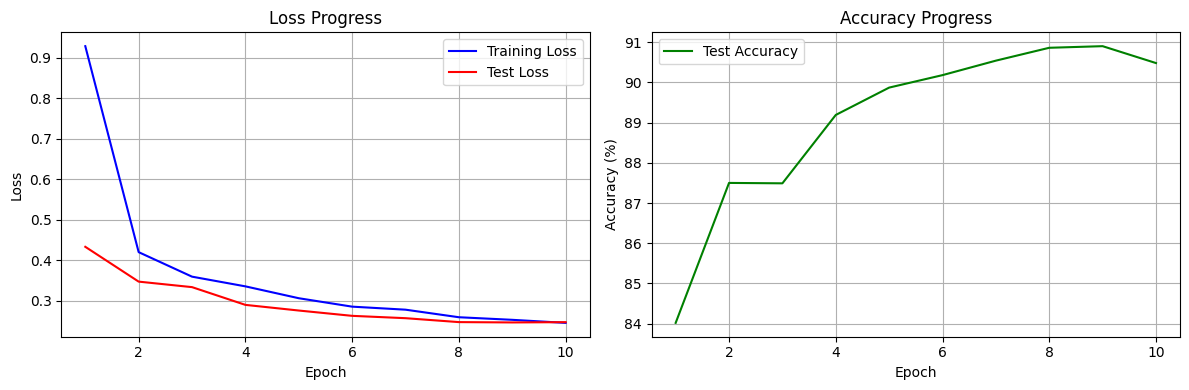

Epoch 10/10 Complete:
  Train Loss: 0.2449
  Test Loss: 0.2467
  Test Accuracy: 90.48%
  Best Accuracy: 90.90%


In [7]:
# Training with real-time plotting
import matplotlib.pyplot as plt
from IPython.display import clear_output


def train_model_with_plots(
    model,
    train_loader,
    test_loader,
    epochs=10,
    start_epoch=0,
    lr=0.001,
    checkpoint_dir="./checkpoints",
    checkpoint_freq=500,
    train_losses=None,
    test_losses=None,
    test_accuracies=None,
):
    train_losses = train_losses or []
    test_losses = test_losses or []
    test_accuracies = test_accuracies or []
    adjusted_lr = lr * batch_size_multiplier if use_multi_gpu else lr
    optimizer = torch.optim.Adam(model.parameters(), lr=adjusted_lr)
    criterion = nn.NLLLoss()

    print(f"Training configuration:")
    print(f"  Learning rate: {adjusted_lr:.6f} (base: {lr:.6f})")
    print(f"  Batch size: {batch_size}")
    print(f"  Multi-GPU: {use_multi_gpu}")
    print(f"  Device: {device}")

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Training loop with simple progress tracking
    for epoch in range(start_epoch, epochs):
        model.train()
        epoch_loss = 0.0

        # Simple progress for each epoch
        print(f"\nEpoch {epoch+1}/{epochs}")
        batch_losses = []

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device, non_blocking=True), target.to(
                device, non_blocking=True
            )

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())
            epoch_loss += loss.item()

            # Print progress every 100 batches
            if (batch_idx + 1) % 100 == 0:
                avg_loss = sum(batch_losses[-100:]) / len(batch_losses[-100:])
                print(
                    f"  Batch {batch_idx+1}/{len(train_loader)}: Loss = {avg_loss:.4f}"
                )

            # Save checkpoint periodically
            if batch_idx % checkpoint_freq == 0 and batch_idx > 0:
                save_checkpoint(
                    model,
                    optimizer,
                    epoch,
                    batch_idx,
                    loss.item(),
                    checkpoint_dir,
                    train_losses,
                    test_losses,
                    test_accuracies,
                )

        # Test at end of epoch
        avg_train_loss = epoch_loss / len(train_loader)
        test_loss, test_acc = test_model(model, test_loader, criterion, device)

        # Store metrics
        train_losses.append(avg_train_loss)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Print epoch results
        print(
            f"  Results: Train Loss = {avg_train_loss:.4f}, Test Loss = {test_loss:.4f}, Test Acc = {test_acc:.2f}%"
        )
        if torch.cuda.is_available():
            print(f"  Memory: {get_gpu_memory_usage()}")

        # Plot progress every few epochs
        if (epoch + 1) % 2 == 0 or epoch == epochs - 1:
            clear_output(wait=True)

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

            epochs_range = range(1, len(train_losses) + 1)
            ax1.plot(epochs_range, train_losses, "b-", label="Training Loss")
            ax1.plot(epochs_range, test_losses, "r-", label="Test Loss")
            ax1.set_title("Loss Progress")
            ax1.set_xlabel("Epoch")
            ax1.set_ylabel("Loss")
            ax1.legend()
            ax1.grid(True)

            ax2.plot(epochs_range, test_accuracies, "g-", label="Test Accuracy")
            ax2.set_title("Accuracy Progress")
            ax2.set_xlabel("Epoch")
            ax2.set_ylabel("Accuracy (%)")
            ax2.legend()
            ax2.grid(True)

            plt.tight_layout()
            plt.show()

            print(f"Epoch {epoch+1}/{epochs} Complete:")
            print(f"  Train Loss: {avg_train_loss:.4f}")
            print(f"  Test Loss: {test_loss:.4f}")
            print(f"  Test Accuracy: {test_acc:.2f}%")
            print(f"  Best Accuracy: {max(test_accuracies):.2f}%")

        # Save checkpoint at end of epoch
        save_checkpoint(
            model,
            optimizer,
            epoch + 1,
            0,
            avg_train_loss,
            checkpoint_dir,
            train_losses,
            test_losses,
            test_accuracies,
        )

    return train_losses, test_losses, test_accuracies


print("Starting training...")
train_losses, test_losses, test_accuracies = train_model_with_plots(
    model,
    train_loader,
    test_loader,
    epochs=epochs,
    start_epoch=start_epoch,
    lr=lr,
    checkpoint_dir=checkpoint_dir,
    train_losses=train_losses,
    test_losses=test_losses,
    test_accuracies=test_accuracies,
)

In [8]:
# Comprehensive model evaluation and visualization
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


def evaluate_model_comprehensive(
    model, test_loader, class_names, device, num_samples=1000
):
    """Comprehensive model evaluation with predictions and metrics"""
    model.eval()

    all_predictions = []
    all_targets = []
    all_probabilities = []
    sample_images = []
    sample_targets = []
    sample_predictions = []
    sample_probabilities = []

    samples_collected = 0

    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Evaluating model"):
            data, target = data.to(device), target.to(device)
            output = model(data)
            probabilities = torch.exp(
                output
            )  # Convert log probabilities to probabilities
            predictions = output.argmax(dim=1)

            # Store all predictions and targets
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

            # Collect samples for visualization
            if samples_collected < num_samples:
                batch_size = data.size(0)
                samples_to_take = min(batch_size, num_samples - samples_collected)

                sample_images.extend(data[:samples_to_take].cpu())
                sample_targets.extend(target[:samples_to_take].cpu().numpy())
                sample_predictions.extend(predictions[:samples_to_take].cpu().numpy())
                sample_probabilities.extend(
                    probabilities[:samples_to_take].cpu().numpy()
                )

                samples_collected += samples_to_take

    return {
        "all_predictions": np.array(all_predictions),
        "all_targets": np.array(all_targets),
        "all_probabilities": np.array(all_probabilities),
        "sample_images": sample_images,
        "sample_targets": np.array(sample_targets),
        "sample_predictions": np.array(sample_predictions),
        "sample_probabilities": np.array(sample_probabilities),
    }


# Run comprehensive evaluation
print("Running comprehensive evaluation...")
results = evaluate_model_comprehensive(model, test_loader, class_names, device)

# Calculate overall accuracy
accuracy = (results["all_predictions"] == results["all_targets"]).mean() * 100
print(f"Overall Test Accuracy: {accuracy:.2f}%")

Running comprehensive evaluation...


Evaluating model:   0%|          | 0/3 [00:00<?, ?it/s]

Overall Test Accuracy: 90.48%


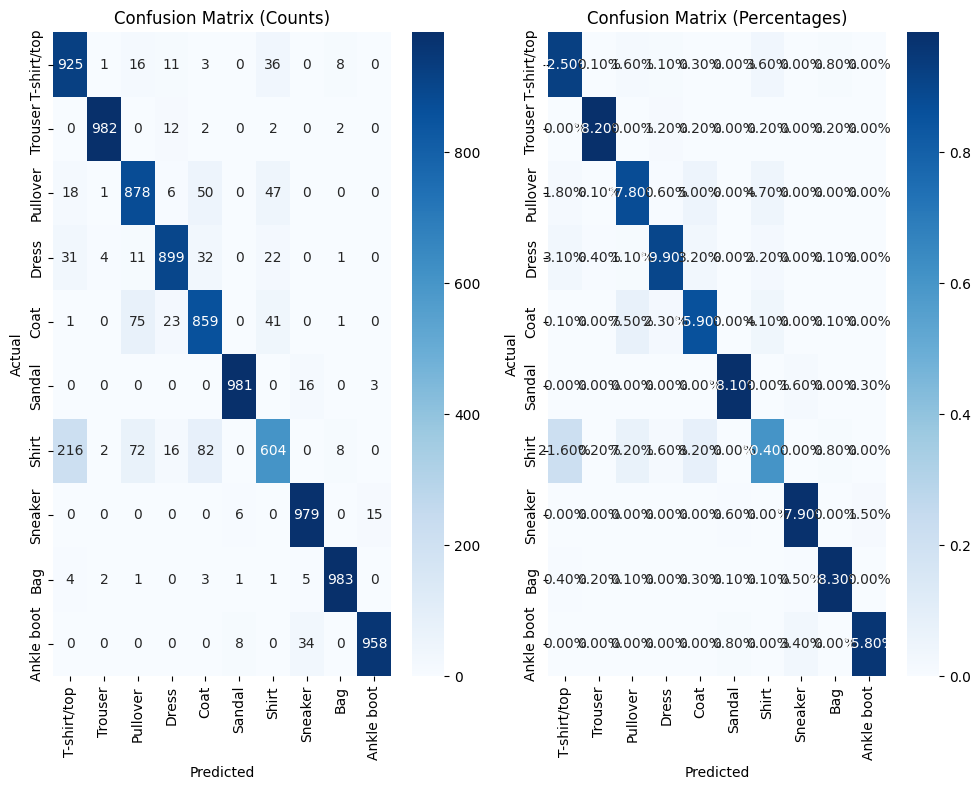


Detailed Classification Report:
              precision    recall  f1-score   support

 T-shirt/top     0.7741    0.9250    0.8428      1000
     Trouser     0.9899    0.9820    0.9859      1000
    Pullover     0.8338    0.8780    0.8553      1000
       Dress     0.9297    0.8990    0.9141      1000
        Coat     0.8332    0.8590    0.8459      1000
      Sandal     0.9849    0.9810    0.9830      1000
       Shirt     0.8021    0.6040    0.6891      1000
     Sneaker     0.9468    0.9790    0.9626      1000
         Bag     0.9801    0.9830    0.9815      1000
  Ankle boot     0.9816    0.9580    0.9696      1000

    accuracy                         0.9048     10000
   macro avg     0.9056    0.9048    0.9030     10000
weighted avg     0.9056    0.9048    0.9030     10000



In [9]:
# Confusion Matrix and Classification Report
def plot_confusion_matrix(y_true, y_pred, class_names, figsize=(10, 8)):
    """Plot confusion matrix with percentages"""
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # Raw counts
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        ax=ax1,
    )
    ax1.set_title("Confusion Matrix (Counts)")
    ax1.set_xlabel("Predicted")
    ax1.set_ylabel("Actual")

    # Normalized percentages
    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt=".2%",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        ax=ax2,
    )
    ax2.set_title("Confusion Matrix (Percentages)")
    ax2.set_xlabel("Predicted")
    ax2.set_ylabel("Actual")

    plt.tight_layout()
    plt.show()

    return cm, cm_normalized


# Plot confusion matrix
cm, cm_norm = plot_confusion_matrix(
    results["all_targets"], results["all_predictions"], class_names
)

# Print classification report
print("\nDetailed Classification Report:")
print("=" * 60)
report = classification_report(
    results["all_targets"],
    results["all_predictions"],
    target_names=class_names,
    digits=4,
)
print(report)

Per-Class Performance:
         Class  Accuracy  Precision  Recall  Support
0  T-shirt/top     0.925     0.7741   0.925     1000
1      Trouser     0.982     0.9899   0.982     1000
2     Pullover     0.878     0.8338   0.878     1000
3        Dress     0.899     0.9297   0.899     1000
4         Coat     0.859     0.8332   0.859     1000
5       Sandal     0.981     0.9849   0.981     1000
6        Shirt     0.604     0.8021   0.604     1000
7      Sneaker     0.979     0.9468   0.979     1000
8          Bag     0.983     0.9801   0.983     1000
9   Ankle boot     0.958     0.9816   0.958     1000


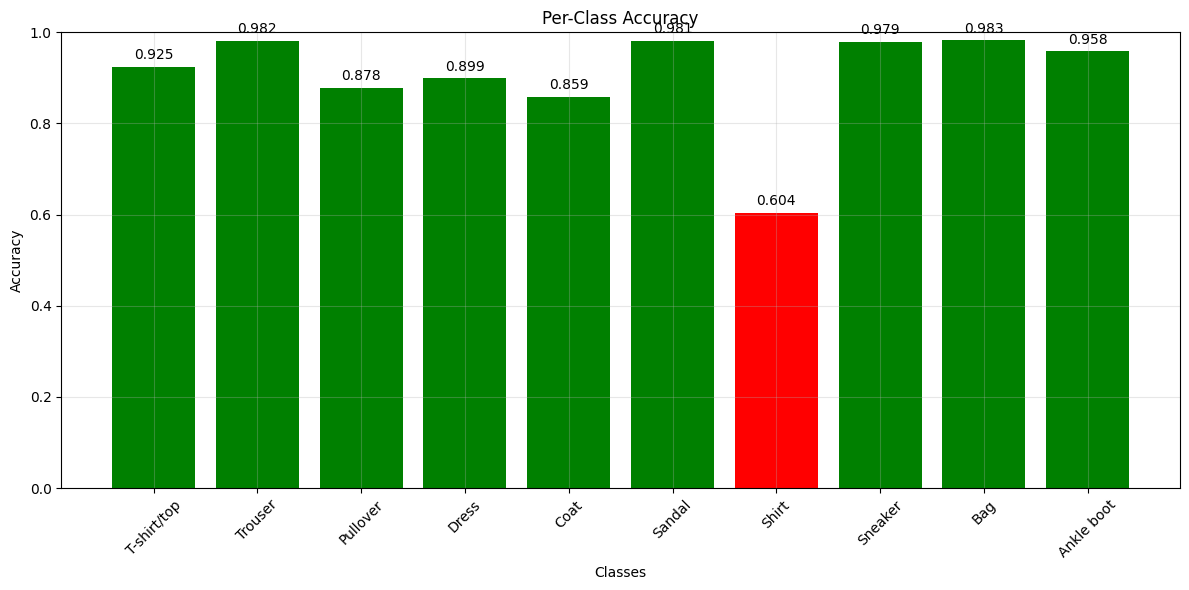

In [10]:
# Per-class accuracy analysis
def analyze_per_class_performance(y_true, y_pred, class_names):
    """Analyze performance per class"""
    cm = confusion_matrix(y_true, y_pred)

    # Calculate per-class metrics
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
    per_class_precision = cm.diagonal() / cm.sum(axis=0)
    per_class_recall = per_class_accuracy  # Same as accuracy for multi-class

    # Create DataFrame for easy viewing
    metrics_df = pd.DataFrame(
        {
            "Class": class_names,
            "Accuracy": per_class_accuracy,
            "Precision": per_class_precision,
            "Recall": per_class_recall,
            "Support": cm.sum(axis=1),
        }
    )

    return metrics_df


# Analyze per-class performance
metrics_df = analyze_per_class_performance(
    results["all_targets"], results["all_predictions"], class_names
)
print("Per-Class Performance:")
print("=" * 70)
print(metrics_df.round(4))

# Plot per-class accuracy
plt.figure(figsize=(12, 6))
bars = plt.bar(
    range(len(class_names)),
    metrics_df["Accuracy"],
    color=[
        "green" if acc > 0.8 else "orange" if acc > 0.7 else "red"
        for acc in metrics_df["Accuracy"]
    ],
)
plt.xlabel("Classes")
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.ylim(0, 1)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.01,
        f"{height:.3f}",
        ha="center",
        va="bottom",
    )

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

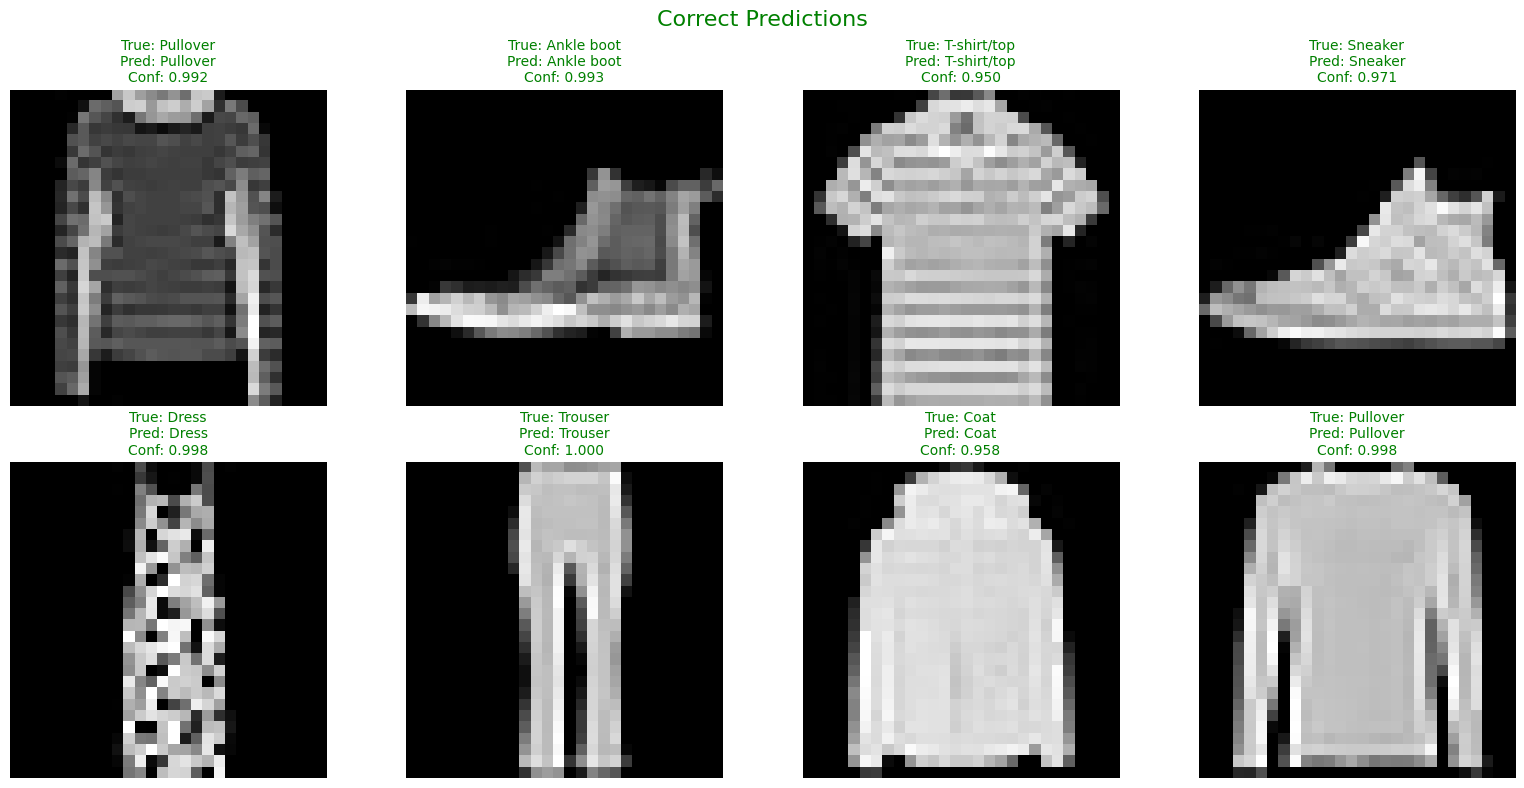

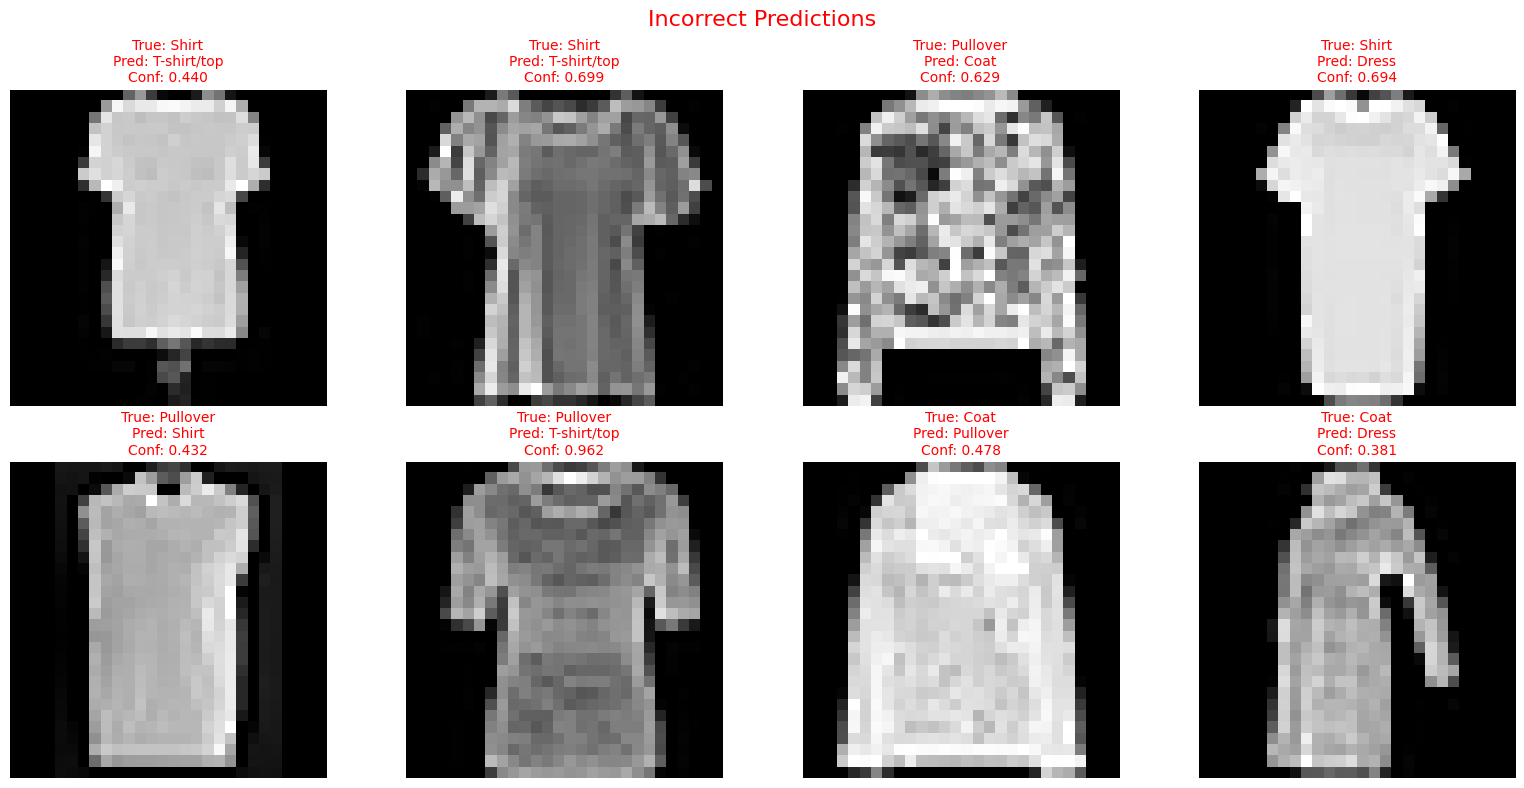

In [11]:
# Prediction examples - Correct and Incorrect
def show_prediction_examples(
    images,
    targets,
    predictions,
    probabilities,
    class_names,
    num_correct=8,
    num_incorrect=8,
):
    """Show examples of correct and incorrect predictions"""

    # Find correct and incorrect predictions
    correct_mask = targets == predictions
    incorrect_mask = ~correct_mask

    correct_indices = np.where(correct_mask)[0]
    incorrect_indices = np.where(incorrect_mask)[0]

    # Randomly sample examples
    if len(correct_indices) > num_correct:
        correct_sample = np.random.choice(correct_indices, num_correct, replace=False)
    else:
        correct_sample = correct_indices

    if len(incorrect_indices) > num_incorrect:
        incorrect_sample = np.random.choice(
            incorrect_indices, num_incorrect, replace=False
        )
    else:
        incorrect_sample = incorrect_indices

    # Plot correct predictions
    if len(correct_sample) > 0:
        fig, axes = plt.subplots(2, min(4, len(correct_sample)), figsize=(16, 8))
        if len(correct_sample) == 1:
            axes = axes.reshape(2, 1)
        fig.suptitle("Correct Predictions", fontsize=16, color="green")

        for i, idx in enumerate(correct_sample[:8]):
            row, col = i // 4, i % 4
            if len(correct_sample) <= 4:
                ax = axes[0, col] if i < 4 else None
                if ax is None:
                    break
            else:
                ax = axes[row, col]

            img = images[idx].squeeze()
            true_label = targets[idx]
            pred_label = predictions[idx]
            confidence = probabilities[idx][pred_label]

            ax.imshow(img, cmap="gray")
            ax.set_title(
                f"True: {class_names[true_label]}\n"
                f"Pred: {class_names[pred_label]}\n"
                f"Conf: {confidence:.3f}",
                color="green",
                fontsize=10,
            )
            ax.axis("off")

        # Hide unused subplots
        for i in range(len(correct_sample), 8):
            row, col = i // 4, i % 4
            if len(correct_sample) <= 4:
                if i >= 4:
                    axes[1, col].axis("off")
            else:
                axes[row, col].axis("off")

        plt.tight_layout()
        plt.show()

    # Plot incorrect predictions
    if len(incorrect_sample) > 0:
        fig, axes = plt.subplots(2, min(4, len(incorrect_sample)), figsize=(16, 8))
        if len(incorrect_sample) == 1:
            axes = axes.reshape(2, 1)
        fig.suptitle("Incorrect Predictions", fontsize=16, color="red")

        for i, idx in enumerate(incorrect_sample[:8]):
            row, col = i // 4, i % 4
            if len(incorrect_sample) <= 4:
                ax = axes[0, col] if i < 4 else None
                if ax is None:
                    break
            else:
                ax = axes[row, col]

            img = images[idx].squeeze()
            true_label = targets[idx]
            pred_label = predictions[idx]
            confidence = probabilities[idx][pred_label]

            ax.imshow(img, cmap="gray")
            ax.set_title(
                f"True: {class_names[true_label]}\n"
                f"Pred: {class_names[pred_label]}\n"
                f"Conf: {confidence:.3f}",
                color="red",
                fontsize=10,
            )
            ax.axis("off")

        # Hide unused subplots
        for i in range(len(incorrect_sample), 8):
            row, col = i // 4, i % 4
            if len(incorrect_sample) <= 4:
                if i >= 4:
                    axes[1, col].axis("off")
            else:
                axes[row, col].axis("off")

        plt.tight_layout()
        plt.show()


# Show prediction examples
show_prediction_examples(
    results["sample_images"],
    results["sample_targets"],
    results["sample_predictions"],
    results["sample_probabilities"],
    class_names,
)

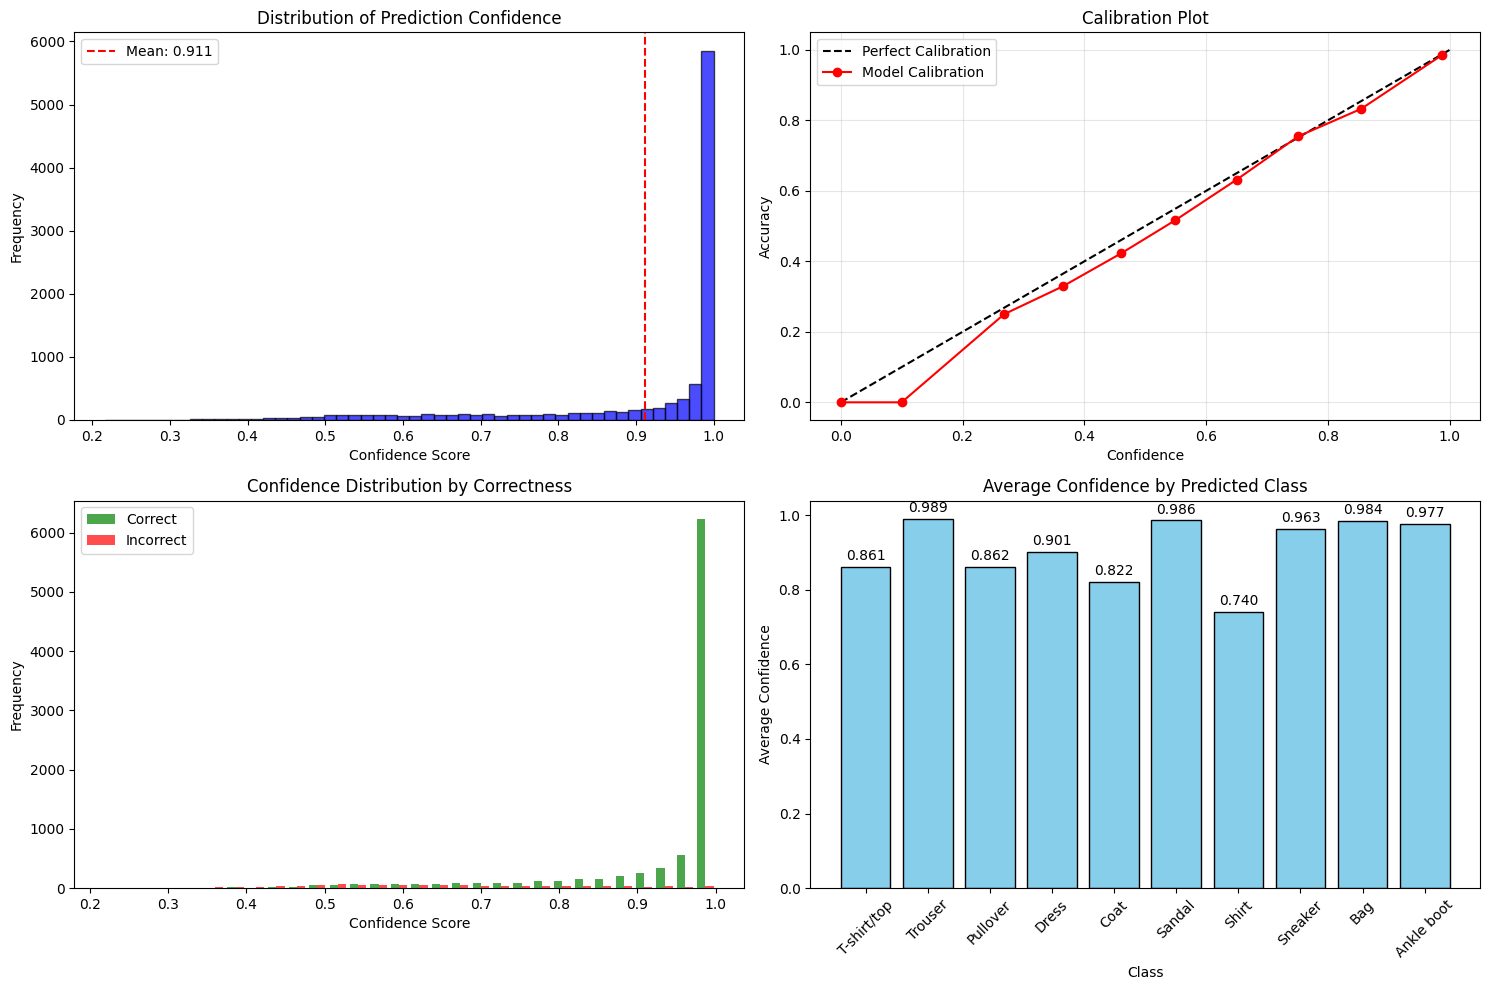

Confidence Analysis:
Mean confidence (all): 0.9113
Mean confidence (correct): 0.9385
Mean confidence (incorrect): 0.6531
Std confidence: 0.1526
Expected Calibration Error: 0.0069


In [12]:
# Confidence analysis and calibration
def analyze_prediction_confidence(probabilities, predictions, targets, class_names):
    """Analyze prediction confidence and calibration"""

    # Get confidence scores (max probability for each prediction)
    confidences = np.max(probabilities, axis=1)
    correct_predictions = predictions == targets

    # Confidence distribution
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Overall confidence distribution
    axes[0, 0].hist(confidences, bins=50, alpha=0.7, color="blue", edgecolor="black")
    axes[0, 0].set_title("Distribution of Prediction Confidence")
    axes[0, 0].set_xlabel("Confidence Score")
    axes[0, 0].set_ylabel("Frequency")
    axes[0, 0].axvline(
        confidences.mean(),
        color="red",
        linestyle="--",
        label=f"Mean: {confidences.mean():.3f}",
    )
    axes[0, 0].legend()

    # Confidence vs Accuracy
    confidence_bins = np.linspace(0, 1, 11)
    bin_accuracies = []
    bin_confidences = []
    bin_counts = []

    for i in range(len(confidence_bins) - 1):
        mask = (confidences >= confidence_bins[i]) & (
            confidences < confidence_bins[i + 1]
        )
        if mask.sum() > 0:
            bin_accuracy = correct_predictions[mask].mean()
            bin_confidence = confidences[mask].mean()
            bin_count = mask.sum()
            bin_accuracies.append(bin_accuracy)
            bin_confidences.append(bin_confidence)
            bin_counts.append(bin_count)
        else:
            bin_accuracies.append(0)
            bin_confidences.append(confidence_bins[i])
            bin_counts.append(0)

    axes[0, 1].plot([0, 1], [0, 1], "k--", label="Perfect Calibration")
    axes[0, 1].plot(bin_confidences, bin_accuracies, "ro-", label="Model Calibration")
    axes[0, 1].set_xlabel("Confidence")
    axes[0, 1].set_ylabel("Accuracy")
    axes[0, 1].set_title("Calibration Plot")
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Confidence by correctness
    correct_conf = confidences[correct_predictions]
    incorrect_conf = confidences[~correct_predictions]

    axes[1, 0].hist(
        [correct_conf, incorrect_conf],
        bins=30,
        alpha=0.7,
        label=["Correct", "Incorrect"],
        color=["green", "red"],
    )
    axes[1, 0].set_title("Confidence Distribution by Correctness")
    axes[1, 0].set_xlabel("Confidence Score")
    axes[1, 0].set_ylabel("Frequency")
    axes[1, 0].legend()

    # Per-class average confidence
    class_confidences = []
    for class_idx in range(len(class_names)):
        class_mask = predictions == class_idx
        if class_mask.sum() > 0:
            class_conf = confidences[class_mask].mean()
        else:
            class_conf = 0
        class_confidences.append(class_conf)

    bars = axes[1, 1].bar(
        range(len(class_names)), class_confidences, color="skyblue", edgecolor="black"
    )
    axes[1, 1].set_title("Average Confidence by Predicted Class")
    axes[1, 1].set_xlabel("Class")
    axes[1, 1].set_ylabel("Average Confidence")
    axes[1, 1].set_xticks(range(len(class_names)))
    axes[1, 1].set_xticklabels(class_names, rotation=45)

    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        axes[1, 1].text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.01,
            f"{height:.3f}",
            ha="center",
            va="bottom",
        )

    plt.tight_layout()
    plt.show()

    # Print confidence statistics
    print("Confidence Analysis:")
    print("=" * 50)
    print(f"Mean confidence (all): {confidences.mean():.4f}")
    print(f"Mean confidence (correct): {correct_conf.mean():.4f}")
    print(f"Mean confidence (incorrect): {incorrect_conf.mean():.4f}")
    print(f"Std confidence: {confidences.std():.4f}")

    # Expected Calibration Error (ECE)
    ece = sum(
        [
            abs(acc - conf) * count
            for acc, conf, count in zip(bin_accuracies, bin_confidences, bin_counts)
        ]
    ) / len(confidences)
    print(f"Expected Calibration Error: {ece:.4f}")


# Analyze confidence
analyze_prediction_confidence(
    results["all_probabilities"],
    results["all_predictions"],
    results["all_targets"],
    class_names,
)

In [13]:
# Most confused classes analysis
def analyze_most_confused_classes(y_true, y_pred, class_names, top_k=5):
    """Find the most commonly confused class pairs"""
    cm = confusion_matrix(y_true, y_pred)

    # Find off-diagonal elements (misclassifications)
    confusion_pairs = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:
                confusion_pairs.append(
                    {
                        "true_class": class_names[i],
                        "pred_class": class_names[j],
                        "count": cm[i, j],
                        "percentage": cm[i, j] / cm[i].sum() * 100,
                    }
                )

    # Sort by count
    confusion_pairs.sort(key=lambda x: x["count"], reverse=True)

    print(f"Top {top_k} Most Confused Class Pairs:")
    print("=" * 80)
    print(
        f"{'True Class':<15} {'Predicted As':<15} {'Count':<8} {'% of True Class':<15}"
    )
    print("-" * 80)

    for pair in confusion_pairs[:top_k]:
        print(
            f"{pair['true_class']:<15} {pair['pred_class']:<15} "
            f"{pair['count']:<8} {pair['percentage']:<15.2f}"
        )

    return confusion_pairs[:top_k]


# Analyze most confused classes
most_confused = analyze_most_confused_classes(
    results["all_targets"], results["all_predictions"], class_names
)

Top 5 Most Confused Class Pairs:
True Class      Predicted As    Count    % of True Class
--------------------------------------------------------------------------------
Shirt           T-shirt/top     216      21.60          
Shirt           Coat            82       8.20           
Coat            Pullover        75       7.50           
Shirt           Pullover        72       7.20           
Pullover        Coat            50       5.00           


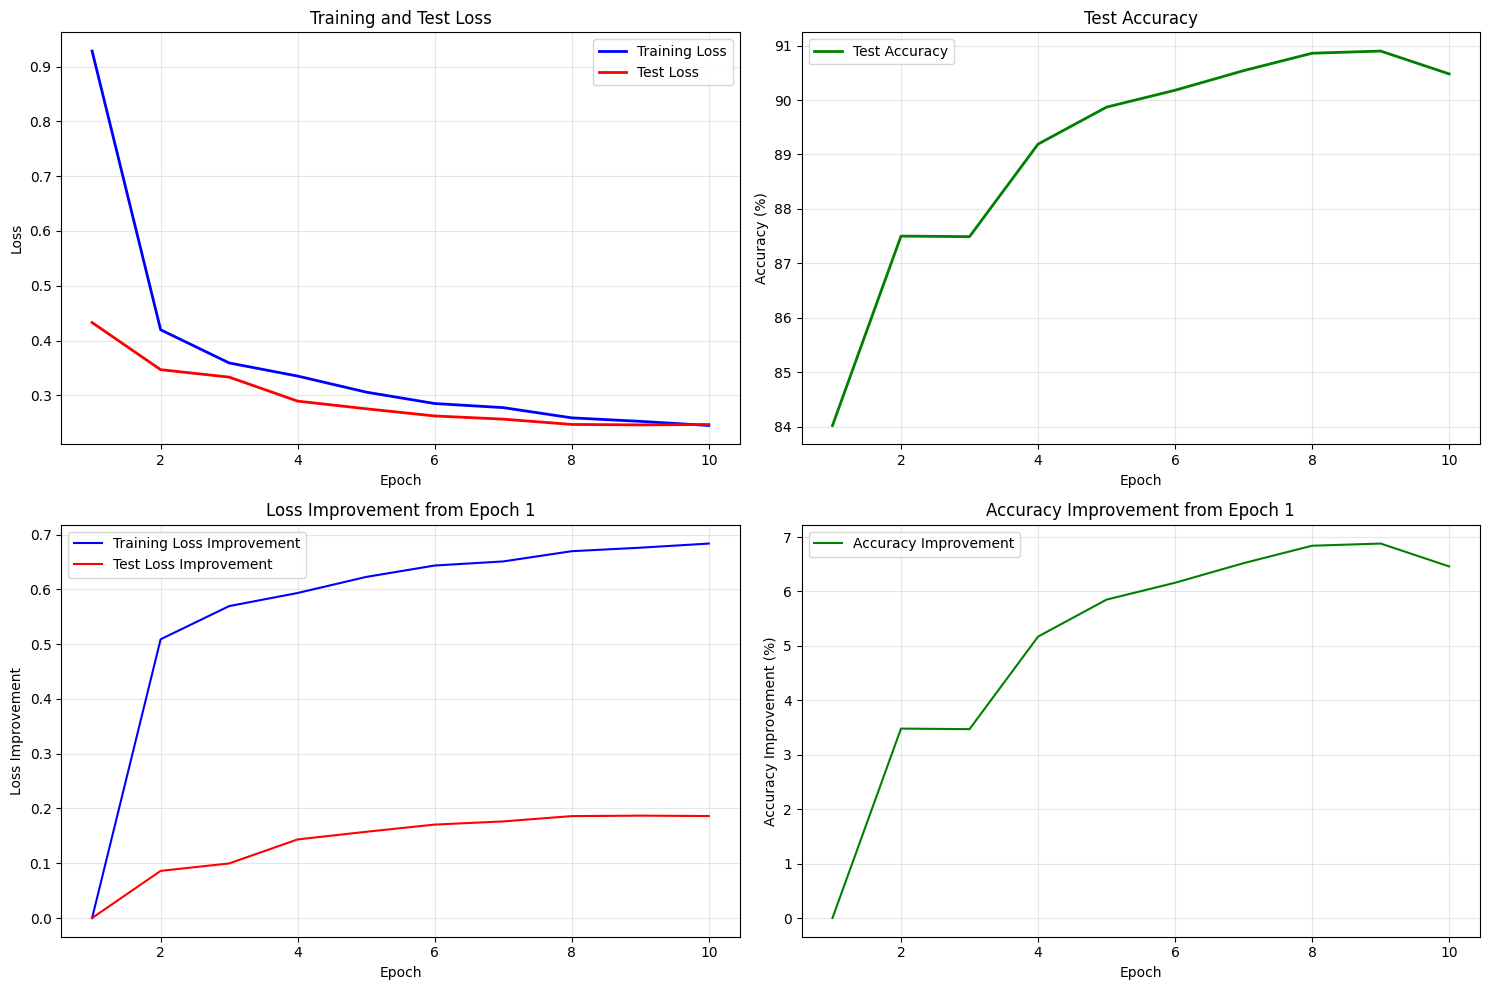

Training Summary:
Initial train loss: 0.9285
Final train loss: 0.2449
Train loss improvement: 0.6836
Initial test accuracy: 84.02%
Final test accuracy: 90.48%
Best test accuracy: 90.90%
Accuracy improvement: 6.88%


In [14]:
# Training history visualization
def plot_training_history(train_losses, test_losses, test_accuracies):
    """Plot comprehensive training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    epochs_range = range(1, len(train_losses) + 1)

    # Loss curves
    axes[0, 0].plot(
        epochs_range, train_losses, "b-", label="Training Loss", linewidth=2
    )
    axes[0, 0].plot(epochs_range, test_losses, "r-", label="Test Loss", linewidth=2)
    axes[0, 0].set_title("Training and Test Loss")
    axes[0, 0].set_xlabel("Epoch")
    axes[0, 0].set_ylabel("Loss")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy curve
    axes[0, 1].plot(
        epochs_range, test_accuracies, "g-", label="Test Accuracy", linewidth=2
    )
    axes[0, 1].set_title("Test Accuracy")
    axes[0, 1].set_xlabel("Epoch")
    axes[0, 1].set_ylabel("Accuracy (%)")
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Loss improvement
    train_loss_improvement = [train_losses[0] - loss for loss in train_losses]
    test_loss_improvement = [test_losses[0] - loss for loss in test_losses]

    axes[1, 0].plot(
        epochs_range, train_loss_improvement, "b-", label="Training Loss Improvement"
    )
    axes[1, 0].plot(
        epochs_range, test_loss_improvement, "r-", label="Test Loss Improvement"
    )
    axes[1, 0].set_title("Loss Improvement from Epoch 1")
    axes[1, 0].set_xlabel("Epoch")
    axes[1, 0].set_ylabel("Loss Improvement")
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Accuracy improvement
    acc_improvement = [acc - test_accuracies[0] for acc in test_accuracies]
    axes[1, 1].plot(epochs_range, acc_improvement, "g-", label="Accuracy Improvement")
    axes[1, 1].set_title("Accuracy Improvement from Epoch 1")
    axes[1, 1].set_xlabel("Epoch")
    axes[1, 1].set_ylabel("Accuracy Improvement (%)")
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print training summary
    print("Training Summary:")
    print("=" * 50)
    print(f"Initial train loss: {train_losses[0]:.4f}")
    print(f"Final train loss: {train_losses[-1]:.4f}")
    print(f"Train loss improvement: {train_losses[0] - train_losses[-1]:.4f}")
    print(f"Initial test accuracy: {test_accuracies[0]:.2f}%")
    print(f"Final test accuracy: {test_accuracies[-1]:.2f}%")
    print(f"Best test accuracy: {max(test_accuracies):.2f}%")
    print(f"Accuracy improvement: {max(test_accuracies) - test_accuracies[0]:.2f}%")


# Plot training history
plot_training_history(train_losses, test_losses, test_accuracies)